# 16 Iterative Solvers

In [1]:
import numpy as np 
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy import sparse

## Problem 1 and 2: Jacobi Method

In [2]:
def jacobi(A, b, tol=1e-8, maxiters=5000, plot=False):
    
    D = np.diagonal(A)
    x_k = np.zeros_like(b)
    err_list = []
    
    err = tol + 1
    iteration = 1
    while (err >= tol) & (iteration < maxiters):
        
        x_k_1 = x_k + (b - A @ x_k) / D 
        err = la.norm(x_k_1 - x_k, np.inf)
        err_list.append(err)
        x_k = x_k_1
        iteration += 1
    
    if plot:
        plt.semilogy(err_list)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi Method')
        plt.show()  
        
    return x_k


In [3]:
def diag_dom(n, num_entries=None):
    '''
    Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
    n (int): The dimension of the system.
    num_entries (int): The number of nonzero values.
    Defaults to n^(3/2)-n.
    Returns:
    A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    '''
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

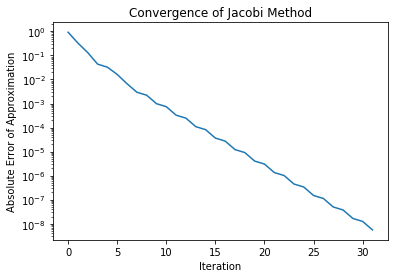

In [4]:
n = 10
A = diag_dom(n)
b = np.random.random(n)
x = jacobi(A, b, plot=True)

In [5]:
np.allclose(A @ x, b)

True

## Problem 3: Gauss-Seidel Method

In [57]:
def gauss_seidel(A, b, tol=1e-8, maxiters=5000, plot=False):
    
    x_k = np.zeros_like(b)
    err_list = []
    
    err = tol + 1
    iteration = 1
    while (err >= tol) & (iteration < maxiters):
        
        x_k_1 = np.copy(x_k)
        for i in range(len(b)):
            x_k_1[i] = x_k[i] + (1 / A[i, i]) * (b[i] - A[i, :].T @ x_k) 
            
        err = la.norm(A @ x_k_1 - b, np.inf)
        err_list.append(err)
        x_k = x_k_1
        iteration += 1
    
    if plot:
        plt.semilogy(err_list)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss-Seidel Method')
        plt.show()  
        
    return x_k

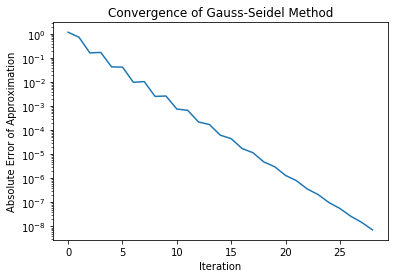

In [71]:
n = 10
A = diag_dom(n)
b = np.random.random(n)
x = gauss_seidel(A, b, plot=True)

In [59]:
np.allclose(A @ x, b)

True

## Problem 4

In [69]:
def gauss_seidel_sparse(A, b, tol=1e-8, maxiters=5000, plot=False):
    
    x_k = np.zeros_like(b)
    err_list = []
    
    err = tol + 1
    iteration = 1
    while (err >= tol) & (iteration < maxiters):
        
        x_k_1 = np.copy(x_k)
        for i in range(len(b)):
            
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            
            x_k_1[i] = x_k[i] + (1 / A[i, i]) * (b[i] - Aix) 
            
        err = la.norm(A @ x_k_1 - b, np.inf)
        err_list.append(err)
        x_k = x_k_1
        iteration += 1
    
    if plot:
        plt.semilogy(err_list)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss-Seidel Sparse Systems Method')
        plt.show()  
        
    return x_k
    

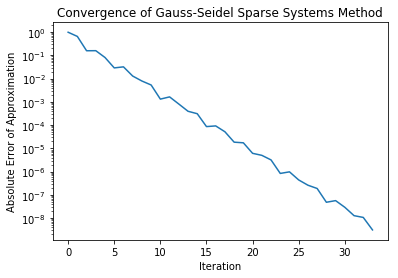

In [70]:
A = sparse.csr_matrix(diag_dom(10))
b = np.random.random(10)
x = gauss_seidel_sparse(A, b, plot=True)

In [62]:
np.allclose(A @ x, b)

True

## Problem 5

In [63]:
def gauss_seidel_SOR(A, b, ω, tol=1e-8, maxiters=5000, plot=False):
    
    x_k = np.zeros_like(b)
    err_list = []
    
    err = tol + 1
    iteration = 1
    while (err >= tol) & (iteration < maxiters):
        
        x_k_1 = np.copy(x_k)
        for i in range(len(b)):
            
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            
            x_k_1[i] = x_k[i] + (ω / A[i, i]) * (b[i] - Aix) 
            
        err = la.norm(A @ x_k_1 - b, np.inf)
        err_list.append(err)
        x_k = x_k_1
        iteration += 1
    
    
    if plot:
        plt.semilogy(err_list)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss-Seidel Successive Over-Relaxation Method')
        plt.show()  
        
    return x_k, iteration

In [113]:
A = sparse.csr_matrix(diag_dom(10))
b = np.random.random(10)

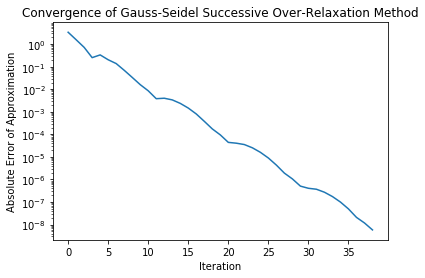

In [120]:
x, iteration = gauss_seidel_SOR(A, b, 1.2, plot=True)

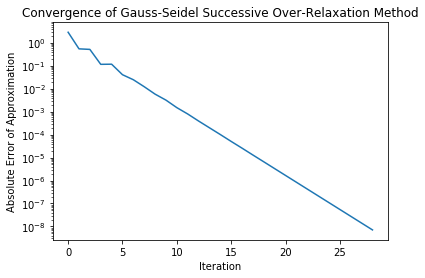

In [121]:
x, iteration = gauss_seidel_SOR(A, b, 1, plot=True)

## Problem 6

In [170]:
def heat_flow(n, ω, tol=1e-8, maxiters=100, plot=False):
    
    # Construction of A: 
    B = sparse.diags([1,-4,1], offsets=[-1,0,1], shape=(n,n)).toarray()
    Bs = sparse.block_diag([B]*n).toarray()
    Is = sparse.diags([1,1], offsets=[-n, n], shape=(n**2,n**2)).toarray()
    A = Bs + Is
    A = sparse.csr_matrix(A)
    
    # Construction of b:
    b = np.zeros(n)
    b[0] = -100
    b[-1]= -100
    b = np.tile(b, n)
    
    u, iteration = gauss_seidel_SOR(A, b, ω, tol, maxiters, plot=False)
    u = u.reshape(n, n)
    
    if plot:
        plt.pcolormesh(u, cmap='coolwarm')
        plt.show()
    
    return u, iteration

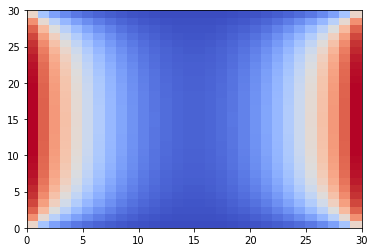

In [171]:
n = 30
ω = 1
u, iteration = heat_flow(n, ω, plot=True)

## Problem 7

In [177]:
def heat_flow_convergence(n):
    
    ω_list = np.linspace(1, 2, 10)
    iterations = []
    for ω in ω_list:
        u, iteration = heat_flow(n, ω, tol=1e-5, maxiters=5000, plot=False)
        iterations.append(iteration)
    
    plt.plot(ω_list, iterations)
    plt.xlabel("ω")
    plt.ylabel("iterations")
    plt.show()
    
    ω_opt = ω_list[np.argmin(iterations)]
    
    return ω_opt

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


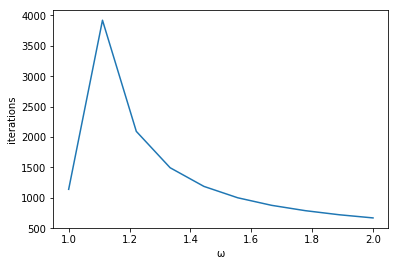

2.0

In [178]:
heat_flow_convergence(20)